In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import shap
shap.initjs()
import seaborn as sns
import random
import os
import sklearn
from shapely import wkt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency
import joblib
import warnings
warnings.filterwarnings('ignore')

from imputación import ImputadorNumerico, ImputadorCategorico, CodificadorCiclico, AgregadorEspacial, transformer_fechas

In [3]:
sklearn.set_config(transform_output="pandas")

## Carga y split de los datos

In [6]:
datos = pd.read_csv("weatherAUS.csv")
datos['RainTomorrow'] = datos['RainTomorrow'].map({'No': 0, 'Yes': 1})
indices_drop = datos[datos['RainTomorrow'].isna()].index
datos = datos.drop(indices_drop)
X = datos.drop(columns=['RainTomorrow'])
y = datos['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
col_numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
col_categoricas = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
col_agrupacion = ['label', 'Mes']
col_ciclicas = ['Mes']

## Regresión Logística

In [9]:
col_entrada_numericas = col_numericas + col_agrupacion

pipe_num = Pipeline([
    ('imputador_custom', ImputadorNumerico(
        variables_imputar = col_numericas,
        variables_contexto = col_agrupacion
    )),
    ('scaler', RobustScaler())
])

pipe_cat = Pipeline([
    ('imputador_custom', ImputadorCategorico(seed = 42)),
    ('ohe', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer([
    ('num', pipe_num, col_entrada_numericas),
    ('cat', pipe_cat, col_categoricas),
    ('cyc', CodificadorCiclico(categorias_ordenadas=np.arange(1, 13)), col_ciclicas)
], verbose_feature_names_out=False)

In [10]:
modelo_logistico = LogisticRegression(
    class_weight = 'balanced', 
    random_state = 13, 
    max_iter = 1000
)

pipeline_completo = Pipeline([
    #Generar Mes y Temporada
    ('feature_eng_date', transformer_fechas),
    #Generar Región (Spatial Join)
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    #Limpiar, Imputar y Escalar
    ('preprocesamiento', preprocessor),
    #Modelo
    ('clasificador', modelo_logistico)
])

pipeline_completo.fit(X_train, y_train)
y_test_predict = pipeline_completo.predict(X_test)

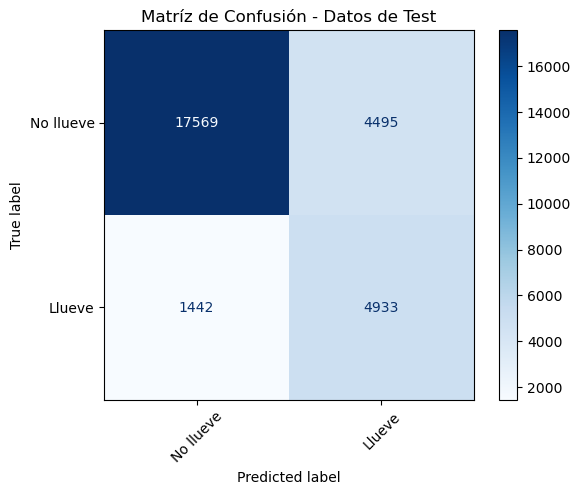

In [11]:
matriz_test =confusion_matrix(y_true = y_test, y_pred = y_test_predict)
ConfusionMatrixDisplay(matriz_test, display_labels=['No llueve', 'Llueve']).plot(cmap=plt.cm.Blues, xticks_rotation=45) #type: ignore
plt.grid(False)
plt.title('Matríz de Confusión - Datos de Test');

In [12]:
print("Métricas en Datos de Test")
reporte_train_1 = classification_report(y_test, y_test_predict, output_dict = True)
df_reporte_train_1 = pd.DataFrame(reporte_train_1).transpose()
df_reporte_train_1.style.background_gradient(cmap = 'Blues').format("{:.2f}")

Métricas en Datos de Test


,precision,recall,f1-score,support
0.0,0.92,0.80,0.86,22064.00
1.0,0.52,0.77,0.62,6375.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.72,0.79,0.74,28439.00
weighted avg,0.83,0.79,0.80,28439.00


## Red Neuronal

In [ ]:
from clases_modelos import RedLluvia
modelo_red_neuronal = RedLluvia(learning_rate = 0.0005, epochs = 100, batch_size = 128,
                 capas_ocultas = [64, 64, 32], dropout_rate = 0.25, random_state = 42)
# --- EL PIPELINE FINAL ---
pipeline_red_neuronal = Pipeline([
    # Paso 1: Generar Mes y Temporada
    ('feature_eng_date', transformer_fechas),
    
    # Paso 2: Generar Región (Spatial Join)
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    
    # Paso 3: Limpiar, Imputar y Escalar (todo lo generado en 1 y 2 + lo original)
    ('preprocesamiento', preprocessor),
    
    # Paso 4: El Modelo
    ('clasificador', modelo_red_neuronal) # Ej: LogisticRegression()
])

pipeline_red_neuronal.fit(X_train, y_train)
y_test_predict = pipeline_red_neuronal.predict(X_test)

## HGBClassifier

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier
from clases_modelos import HGBClassifier

modelo_lgbm_sklearn = HGBClassifier(
    learning_rate = 0.01,
    max_iter = 100,
    random_state = 42,
    class_weight = 'balanced'
)

# Creamos el Pipeline con el NUEVO modelo
pipeline_lgbm = Pipeline([
    # Paso 1: Fechas
    ('feature_eng_date', transformer_fechas),
    # Paso 2: Geo
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),

    # Paso 3: Limpieza (Nota: HistGradientBoosting tolera nulos, pero el OneHotEncoder de tu pipe_cat NO,
    # así que mantén tu 'pipeline_procesamiento' tal cual está para las categóricas).
    ('preprocesamiento', preprocessor),
    
    # Paso 4: El Modelo LightGBM de Sklearn
    ('clasificador', modelo_lgbm_sklearn) 
])

# Entrenar y Validar
pipeline_lgbm.fit(X_train, y_train)
print("Score en Test:", pipeline_lgbm.score(X_test, y_test))

Score en Test: 0.82059847392665


Reporte de Clasificación - HistGradientBoosting:
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88     22064
         1.0       0.59      0.67      0.63      6375

    accuracy                           0.82     28439
   macro avg       0.74      0.77      0.75     28439
weighted avg       0.83      0.82      0.82     28439



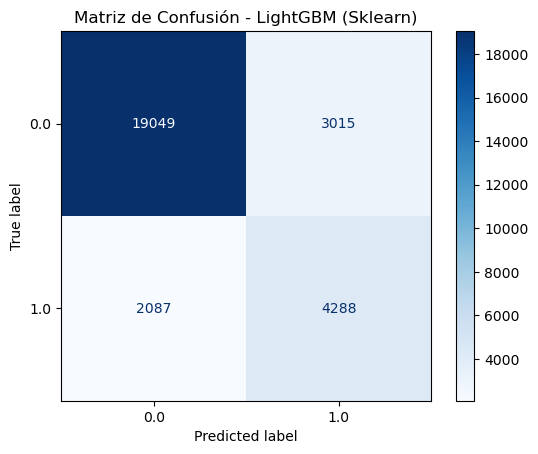

In [14]:
# 1. Predecir las clases
y_pred_lgbm = pipeline_lgbm.predict(X_test)

# 2. Ver el reporte detallado
print("Reporte de Clasificación - HistGradientBoosting:")
print(classification_report(y_test, y_pred_lgbm))

# 3. Ver la matriz de confusión (para ver dónde se equivoca)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm, cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - LightGBM (Sklearn)")
plt.show()

In [15]:
import json

# Cargamos la configuración
with open('config_hgbc_optimizado.json', 'r') as f:
    params = json.load(f)

print("Cargando modelo con:", params)

# Instanciamos automáticamente
model = HistGradientBoostingClassifier(**params)

Cargando modelo con: {'learning_rate': 0.05109918125800657, 'max_iter': 571, 'max_leaf_nodes': 98, 'min_samples_leaf': 75, 'l2_regularization': 1.1871370566332745e-05, 'class_weight': 'balanced', 'random_state': 42, 'early_stopping': True, 'validation_fraction': 0.1, 'scoring': 'loss'}


In [16]:
# 1. Predecir las clases
pipeline_lgbm_op = Pipeline([
    # Paso 1: Fechas
    ('feature_eng_date', transformer_fechas),
    # Paso 2: Geo
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    # Paso 3: Limpieza (Nota: HistGradientBoosting tolera nulos, pero el OneHotEncoder de tu pipe_cat NO,
    # así que mantén tu 'pipeline_procesamiento' tal cual está para las categóricas).
    ('preprocesamiento', preprocessor),
    # Paso 4: El Modelo LightGBM de Sklearn
    ('clasificador', model) 
])
pipeline_lgbm_op.fit(X_train, y_train)
y_pred_lgbm_op = pipeline_lgbm_op.predict(X_test)

In [17]:
# 2. Ver el reporte detallado
print("Reporte de Clasificación - HistGradientBoosting op:")
reporte_hgbc = classification_report(y_test, y_pred_lgbm_op, output_dict = True)
df_reporte_hgbc = pd.DataFrame(reporte_hgbc).transpose()
df_reporte_hgbc.style.background_gradient(cmap = 'Blues').format("{:.2f}")

Reporte de Clasificación - HistGradientBoosting op:


,precision,recall,f1-score,support
0.0,0.93,0.83,0.88,22064.00
1.0,0.57,0.78,0.66,6375.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.75,0.81,0.77,28439.00
weighted avg,0.85,0.82,0.83,28439.00


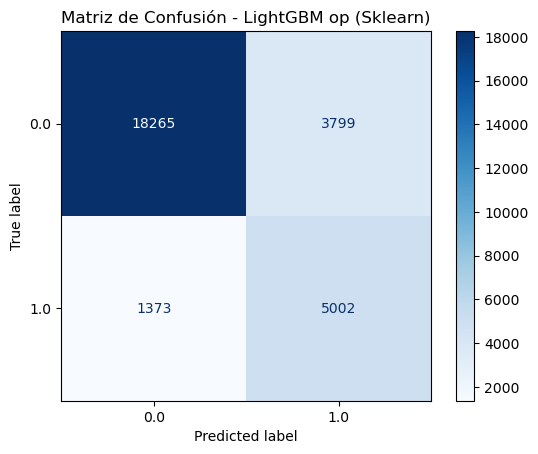

In [18]:
# 3. Ver la matriz de confusión (para ver dónde se equivoca)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm_op, cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - LightGBM op (Sklearn)")
plt.show()

## Random Forest

In [19]:
from clases_modelos import RFClassifier

modelo_rf = RFClassifier(
    n_estimators= 100,
    random_state=42
)

# Creamos el Pipeline con el NUEVO modelo
pipeline_rf = Pipeline([
    # Paso 1: Fechas
    ('feature_eng_date', transformer_fechas),
    
    # Paso 2: Geo
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    
    ('preprocesamiento', preprocessor),
    
    # Paso 4: El Modelo LightGBM de Sklearn
    ('clasificador', modelo_rf) 
])

# Entrenar y Validar
pipeline_rf.fit(X_train, y_train)
print("Score en Test:", pipeline_lgbm.score(X_test, y_test))

Score en Test: 0.82059847392665


Reporte de Clasificación - RandomForest:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     22064
         1.0       0.64      0.67      0.66      6375

    accuracy                           0.84     28439
   macro avg       0.77      0.78      0.78     28439
weighted avg       0.85      0.84      0.84     28439



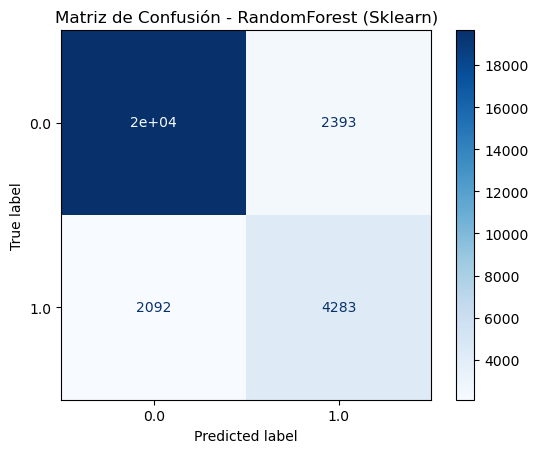

In [20]:
# 1. Predecir las clases
y_pred_rf = pipeline_rf.predict(X_test)

# 2. Ver el reporte detallado
print("Reporte de Clasificación - RandomForest:")
print(classification_report(y_test, y_pred_rf))

# 3. Ver la matriz de confusión (para ver dónde se equivoca)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap = plt.cm.Blues)
plt.title("Matriz de Confusión - RandomForest (Sklearn)")
plt.show()

In [21]:
import json

# Cargamos la configuración
with open('config_rf_optimizado.json', 'r') as f:
    params = json.load(f)

print("Cargando modelo con:", params)

# Instanciamos automáticamente
model = RFClassifier(**params)

Cargando modelo con: {'n_estimators': 282, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42}


Reporte de Clasificación - RandomForest op:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     22064
         1.0       0.64      0.69      0.66      6375

    accuracy                           0.84     28439
   macro avg       0.77      0.79      0.78     28439
weighted avg       0.85      0.84      0.85     28439



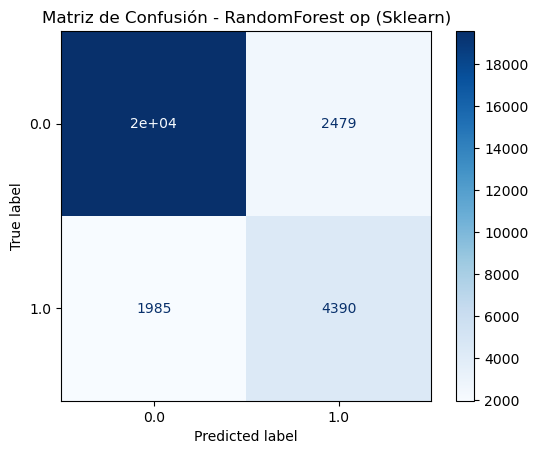

In [22]:
# 1. Predecir las clases
pipeline_rf_op = Pipeline([
    # Paso 1: Fechas
    ('feature_eng_date', transformer_fechas),
    # Paso 2: Geo
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    # Paso 3: Limpieza (Nota: HistGradientBoosting tolera nulos, pero el OneHotEncoder de tu pipe_cat NO,
    # así que mantén tu 'pipeline_procesamiento' tal cual está para las categóricas).
    ('preprocesamiento', preprocessor),
    # Paso 4: El Modelo LightGBM de Sklearn
    ('clasificador', model) 
])
pipeline_rf_op.fit(X_train, y_train)
y_pred_rf_op = pipeline_rf_op.predict(X_test)

# 2. Ver el reporte detallado
print("Reporte de Clasificación - RandomForest op:")
print(classification_report(y_test, y_pred_rf_op))

# 3. Ver la matriz de confusión (para ver dónde se equivoca)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_op, cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - RandomForest op (Sklearn)")
plt.show()